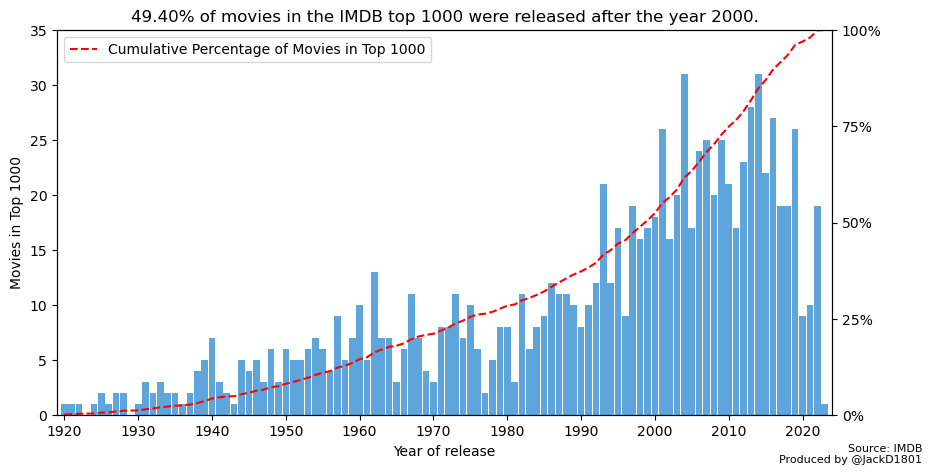

In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import os

# Define the paths for the input, output and data folders
SCRIPT_PATH = "Plot5Top1000Movies/Script/"
DATA_PATH = "../Data/"
OUTPUT_PATH = "../Output/"

# Define the URL for the top 1000 movies on IMDb
IMDB_URL = "https://www.imdb.com/search/title/?groups=top_1000&start={}"

# Define the filename for the output data
DATA_FILENAME = "data.csv"

# Define the filename for the output plot
PLOT_FILENAME = "plot5.jpeg"


def extract_data():
    """
    Extracts data from the IMDb website and saves it to a CSV file
    """
    # Create an empty list to hold the data for each movie
    movies = []

    # Loop through each page of results (there are 20)
    for page in range(1, 21):
        # URL for the current page of results
        url = IMDB_URL.format(((page-1)*50)+1)

        # Send a GET request to the URL
        response = requests.get(url)

        # Use BeautifulSoup to parse the HTML content of the response
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find all the movie listings on the page
        movie_listings = soup.find_all('div', class_='lister-item mode-advanced')

        # Loop through each movie listing and extract the data
        for movie in movie_listings:
            # Extract the title of the movie
            title = movie.h3.a.text.strip()

            # Extract the year the movie was released
            year = movie.h3.find('span', class_='lister-item-year').text.strip('()')


            # Extract the overall rating of the movie on IMDb
            rating = movie.find('div', class_='inline-block ratings-imdb-rating').text.strip()

            # Append the data for this movie to the movies list
            movies.append({'Title': title, 'Year': year, 'Rating': rating})

    # Create a pandas dataframe from the movies list
    df = pd.DataFrame(movies)

    # Save the dataframe to a CSV file
    df.to_csv(DATA_PATH + DATA_FILENAME, index=False)


def plot_data():
    """
    Plots the data from the CSV file and saves the plot to a file
    """
    # Load the data from the CSV file
    df = pd.read_csv(DATA_PATH + DATA_FILENAME)

    # Extract the year from the release date
    df['Year'] = df['Year'].str.extract('(\d{4})')

    # Calculate the percentage of movies released after the year 2000
    df['Year'] = pd.to_numeric(df['Year'], errors='coerce')
    df_after_2000 = df[df['Year'] >= 2000]
    percent_after_2000 = len(df_after_2000) / len(df) * 100

    # Calculate the percentage of movies by year of release
    percent_movies = df['Year'].value_counts(normalize=True).sort_index() * 100

    # Create a bar chart showing the frequency of movies by year of release
    fig, ax = plt.subplots(figsize=(10,5))
    ax1 = ax.twinx()
    ax.bar(percent_movies.index, df['Year'].value_counts().sort_index().values, color='#5DA5DA', width=0.9)
        # Add chart title and labels
    ax.set_title('Frequency of Movies by Year of Release')
    ax.set_ylabel('Movies in Top 1000')
    ax.set_xlabel('Year of release')
    ax.set_xlim(min(df['Year'].unique())-1, max(df['Year'].unique())+1)
    ax.set_ylim(0,35)

    # Plot cumulative percentage of movies in top 1000
    ax1.plot(percent_movies.cumsum(), linestyle='--', color='red', label='Cumulative Percentage of Movies in Top 1000')
    ax1.set_ylim(0,100)
    ax1.set_ylabel('')
    ax1.set_yticks([0, 25, 50, 75, 100])
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend(loc='upper left')

    # Set x-axis ticks to show every 10 years
    plt.xticks(range(min(df['Year'].unique()), max(df['Year'].unique())+1, 10), rotation=90)

    # Print the percentage of movies released after the year 2000 in the chart title
    ax.set_title(f'{percent_after_2000:.2f}% of movies in the IMDB top 1000 were released after the year 2000.')

    # Add a caption to the plot
    caption = 'Source: IMDB\nProduced by @JackD1801'
    plt.figtext(0.99, 0.01, caption, horizontalalignment='right', fontsize=8, va='bottom')

    # Save the plot to a file
    plt.savefig(OUTPUT_PATH + PLOT_FILENAME, dpi=800)


if __name__ == "__main__":
    # Ensure the data and output directories exist
    os.makedirs(DATA_PATH, exist_ok=True)
    os.makedirs(OUTPUT_PATH, exist_ok=True)

    # Extract the data from the IMDb website and save it to a CSV file
    extract_data()

    # Plot the data from the CSV file and save the plot to a file
    plot_data()

